# Visualisations - Analyse des Alertes ANSSI & Enrichissement CVE

## Imports préalables

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# 1️⃣ Racine = dossier parent de notebooks/
PROJECT_ROOT = Path.cwd().resolve().parent
print("📁 Racine projet :", PROJECT_ROOT)

# 2️⃣ Rendre les modules internes importables
sys.path.insert(0, str(PROJECT_ROOT))

# 3️⃣ Chemins communs
DATA_CSV   = PROJECT_ROOT / "data" / "processed" / "final_dataset.csv"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)   # ✅ syntaxe correcte

print("CSV présent :", DATA_CSV.exists(), "-", DATA_CSV)

# 4️⃣ Imports internes (désormais visibles)
from src.extract_cves import extract_all_entries
from src.consolidate import build_dataframe

📁 Racine projet : C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ
CSV présent : True - C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ\data\processed\final_dataset.csv


## Gravité et risques d'exploitation

### Scatter « CVSS × EPSS »

Nous cherchons à savoir **quelles CVE cumulent sévérité et probabilité**.

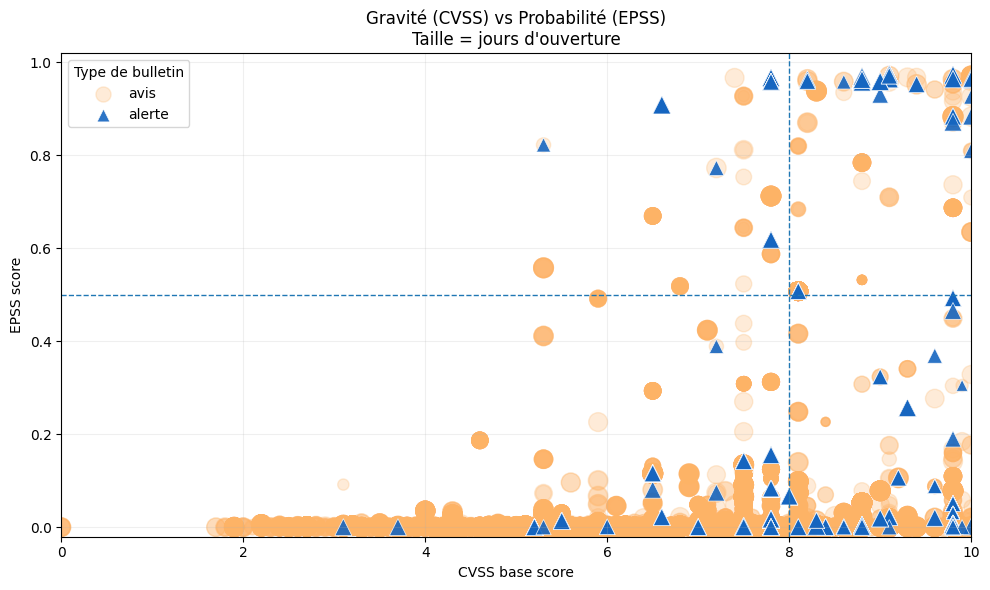

637 urgences enregistrées → C:\Users\thoma\OneDrive\Bureau\Atelier-Data\AtelierDS_PRJ\outputs\urgences_cve.csv


In [3]:
df = pd.read_csv(DATA_CSV, parse_dates=["date", "closed_at"])

# Nettoyage minimal
df = df.dropna(subset=["cvss_score", "epss_score"])
df["cvss_score"] = pd.to_numeric(df["cvss_score"], errors="coerce")
df["epss_score"] = pd.to_numeric(df["epss_score"], errors="coerce")

# Taille des bulles : log(1 + days_open) pour garder lisible
df["size_pt"] = np.log1p(df["days_open"]).fillna(0) * 30

plt.figure(figsize=(10, 6))

# 1️⃣ tracer d’abord les AVIS (orange, transparence)
subset_avis = df[df["type"] == "avis"]
plt.scatter(
    subset_avis["cvss_score"],
    subset_avis["epss_score"],
    s=subset_avis["size_pt"],
    c="#FDB366",                  # orange plus clair
    alpha=0.25,                   # forte transparence
    label="avis",
    marker="o"
)

# 2️⃣ tracer ensuite les ALERTES (bleu, opaques, bord blanc)
subset_alertes = df[df["type"] == "alerte"]
plt.scatter(
    subset_alertes["cvss_score"],
    subset_alertes["epss_score"],
    s=subset_alertes["size_pt"],
    c="#1565C0",                  # bleu plus sombre
    alpha=0.9,
    label="alerte",
    marker="^",                   # triangle
    edgecolors="white",
    linewidths=0.5
)

# Lignes seuils
plt.axvline(8,  linestyle="--", linewidth=1)
plt.axhline(0.5, linestyle="--", linewidth=1)

plt.xlabel("CVSS base score")
plt.ylabel("EPSS score")
plt.title("Gravité (CVSS) vs Probabilité (EPSS)\nTaille = jours d'ouverture")
plt.legend(title="Type de bulletin")
plt.ylim(-0.02, 1.02)
plt.xlim(0, 10)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Export des urgences (quadrant haut-droit)
urgences = df[(df["cvss_score"] >= 8) & (df["epss_score"] >= 0.5)]
urgences.to_csv(OUTPUT_DIR / "urgences_cve.csv", index=False, encoding="utf-8")
print(f"{len(urgences)} urgences enregistrées → {OUTPUT_DIR / 'urgences_cve.csv'}")

### Courbe cumulative des vulnérabilités en fonction du temps

Montrer l’évolution temporelle du nombre de vulnérabilités détectées.

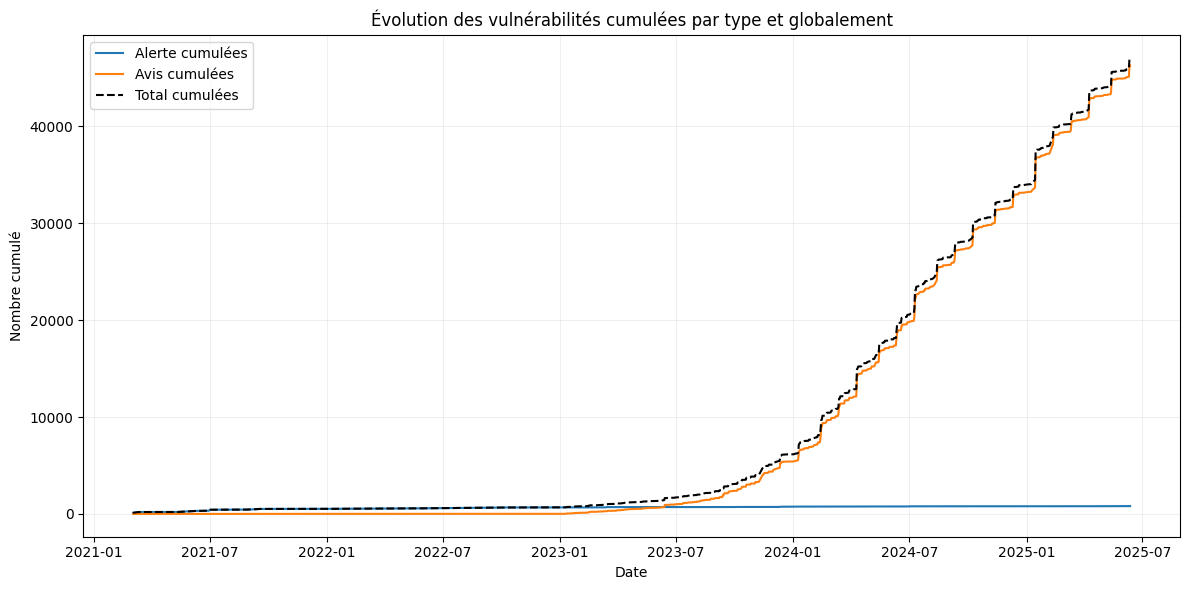

In [9]:
plt.figure(figsize=(12, 6))

# Regrouper par date et compter les vulnérabilités cumulées pour chaque type
vulnerabilites_cumulatives_par_type = df.groupby(["date", "type"]).size().unstack(fill_value=0).cumsum()

# Tracer les courbes cumulées par type
for col in vulnerabilites_cumulatives_par_type.columns:
    plt.plot(
        vulnerabilites_cumulatives_par_type.index,
        vulnerabilites_cumulatives_par_type[col],
        label=f"{col.capitalize()} cumulées"
    )

# Tracer la courbe cumulée globale
vulnerabilites_cumulatives_totales = df.groupby("date").size().cumsum()
plt.plot(
    vulnerabilites_cumulatives_totales.index,
    vulnerabilites_cumulatives_totales.values,
    color="black",
    linestyle="--",
    label="Total cumulées"
)

plt.xlabel("Date")
plt.ylabel("Nombre cumulé")
plt.title("Évolution des vulnérabilités cumulées par type et globalement")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

### Boxplot des scores CVSS par éditeur

Montrer **la dispersion des scores CVSS** pour les éditeurs les plus affectés.

<Figure size 1200x600 with 0 Axes>

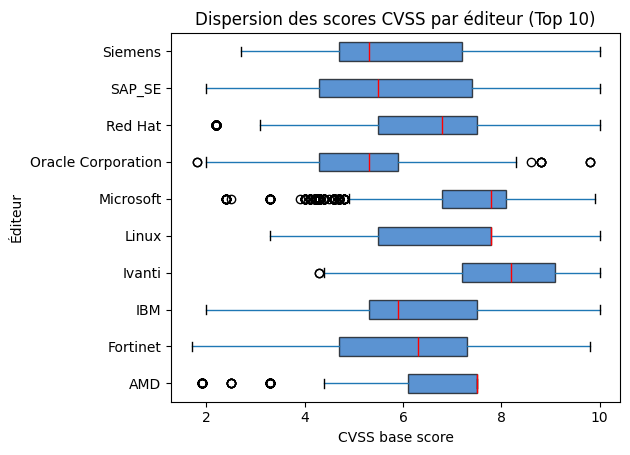

In [5]:
plt.figure(figsize=(12, 6))

# Filter top vendors by count of vulnerabilities
top_vendors = df["vendor"].value_counts().head(10).index
subset_top_vendors = df[df["vendor"].isin(top_vendors)]

# Create boxplot
subset_top_vendors.boxplot(
    column="cvss_score",
    by="vendor",
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="#1565C0", alpha=0.7),
    medianprops=dict(color="red"),
    vert=False
)

plt.title("Dispersion des scores CVSS par éditeur (Top 10)")
plt.suptitle("")  # Remove default title
plt.xlabel("CVSS base score")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()

### Treemap Bulletins, pour la taille d'impact des bulletins

Déniche les bulletins "massifs", parfois sous-estimés

In [6]:
import plotly.express as px

# Calcul le nombre de produits affectés par CVE
df["n_affected_products"] = df["versions"].apply(lambda x: len(str(x).split("|")) if pd.notnull(x) else 0)

# Filtre pour les 100 plus impactants
top_50_alertes_avis = df[df["type"].isin(["alerte", "avis"])].nlargest(100, "n_affected_products")

# Agrégation pour la treemap
treemap_data = top_50_alertes_avis.groupby(["type", "id_anssi"]).agg(
    n_affected_products=("n_affected_products", "sum"),
    titre=("titre", "first")
).reset_index()


treemap_data = treemap_data.sort_values(by="n_affected_products", ascending=False)

# Créer une treemap avec plotly.express
fig = px.treemap(
    treemap_data,
    path=["type", "id_anssi", "titre"],
    color="n_affected_products",
    values="n_affected_products",
    color_continuous_scale='RdBu',
    color_continuous_midpoint=np.average(treemap_data['n_affected_products'], weights=treemap_data['n_affected_products'])
)

fig.update_layout(
    title="Treemap Bulletins - Taille d'impact des bulletins",
    margin=dict(t=50, l=25, r=25, b=25)
)

fig.show()


### Scatter Nombre de références avec EPSS : Attention il faudrait récupérer les données n_cve_refs

Evalue la popularité/médiatisation. Plus de sources implique un risque médiatique et une exploitation probable

### Stacked Area :

Total des vulnérabilités vs subset "CVSS >= 8 et EPSS >= 0.5" : **Suit l'évolution du "backlog critique"**

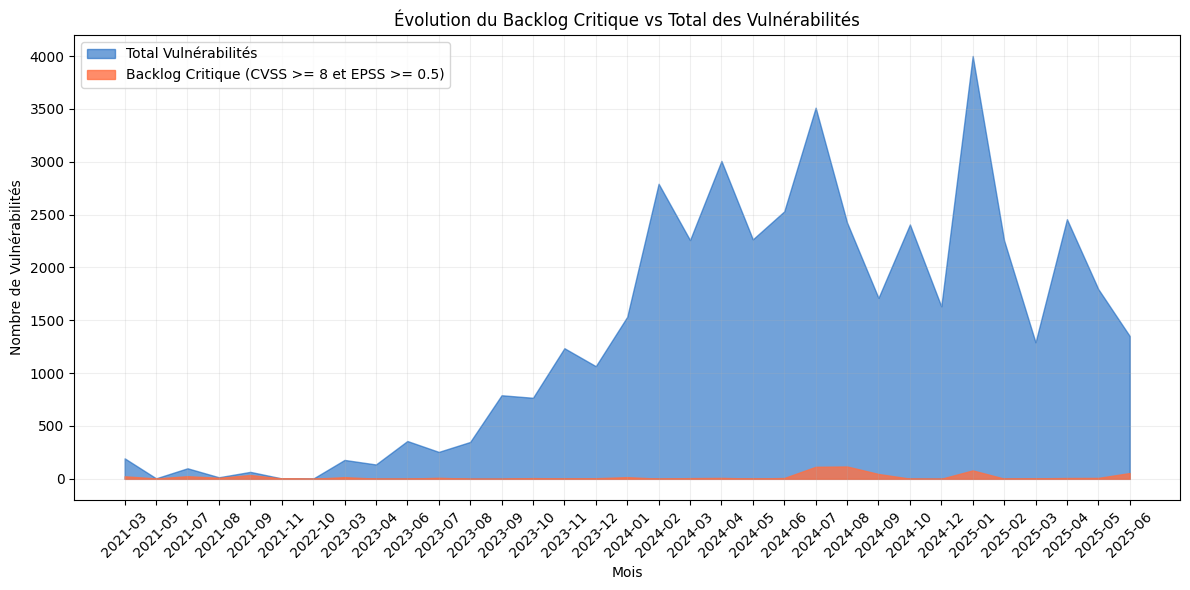

In [ ]:
# Ensure the original dataframe remains unaltered
df_copy = df.copy()

# Group by month and count total vulnerabilities
df_copy["month"] = df_copy["date"].dt.to_period("M")
monthly_total = df_copy.groupby("month").size()

# Filter subset with "CVSS >= 8 and EPSS >= 0.5"
critical_subset = df_copy[(df_copy["cvss_score"] >= 8) & (df_copy["epss_score"] >= 0.5)]
monthly_critical = critical_subset.groupby("month").size()

# Align indices for plotting
monthly_total = monthly_total.reindex(monthly_critical.index, fill_value=0)

plt.figure(figsize=(12, 6))

# Plot stacked area chart
plt.fill_between(monthly_total.index.astype(str), monthly_total.values, color="#1565C0", alpha=0.6, label="Total Vulnérabilités")
plt.fill_between(monthly_critical.index.astype(str), monthly_critical.values, color="#FF7043", alpha=0.8, label="Backlog Critique (CVSS >= 8 et EPSS >= 0.5)")

plt.xlabel("Mois")
plt.ylabel("Nombre de Vulnérabilités")
plt.xticks(rotation=45)
plt.title("Évolution du Backlog Critique vs Total des Vulnérabilités")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

Peut-être utiliser une fenêtre plus récente.

## Courbe de l'évolution de CWE au cours du temps

Permet d'observer l'évolution d'un type de CWE

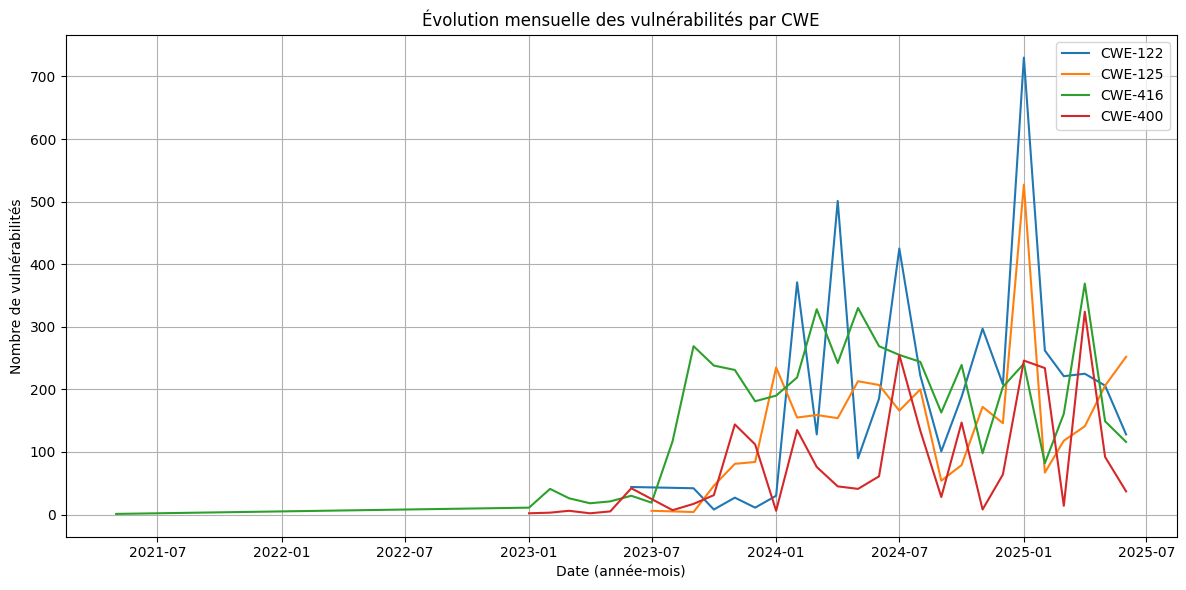

In [ ]:
cwe_list = ["CWE-122", "CWE-125", "CWE-416", "CWE-400"]

plt.figure(figsize=(12, 6))

for cwe in cwe_list:
    temp = df[df["cwe"] == cwe].copy()
    temp["date"] = pd.to_datetime(temp["date"], errors='coerce')
    temp = temp.dropna(subset=["date"])
    
    # Extraire l'année + mois
    temp["year_month"] = temp["date"].dt.to_period("M")
    
    # Compter le nombre de vulnérabilités par mois
    counts = temp["year_month"].value_counts().sort_index()
    
    # Convertir pour le tracé
    counts.index = counts.index.to_timestamp()
    
    plt.plot(counts.index, counts.values, label=cwe)

plt.title("Évolution mensuelle des vulnérabilités par CWE")
plt.xlabel("Date (année-mois)")
plt.ylabel("Nombre de vulnérabilités")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
